# Credit Scoring Competition

## 1. Import libs

In [215]:
import pandas as pd
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

import scikitplot as skplt

import os
import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot

from catboost import CatBoostClassifier, Pool, cv
import missingno as msno

import folium

pyo.init_notebook_mode(connected=True)
cf.go_offline()

#for dirname, _, filenames in os.walk('/kaggle'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [216]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

CURRENT_DATE = pd.to_datetime('15/09/2020')

## 2. Data preparing

In [217]:
DATA_DIR = 'C:/Users/Игорь/dst-4/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

pd.set_option('display.max_columns', None)

In [218]:
print ("формат обучающей выборки:", df_train.shape)
print ("формат тестовой выборки:", df_test.shape)
print ("формат submission:", sample_submission.shape)

формат обучающей выборки: (73799, 19)
формат тестовой выборки: (36349, 18)
формат submission: (24354, 2)


In [219]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [220]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [221]:
df_train.head(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

In [222]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

<AxesSubplot:>

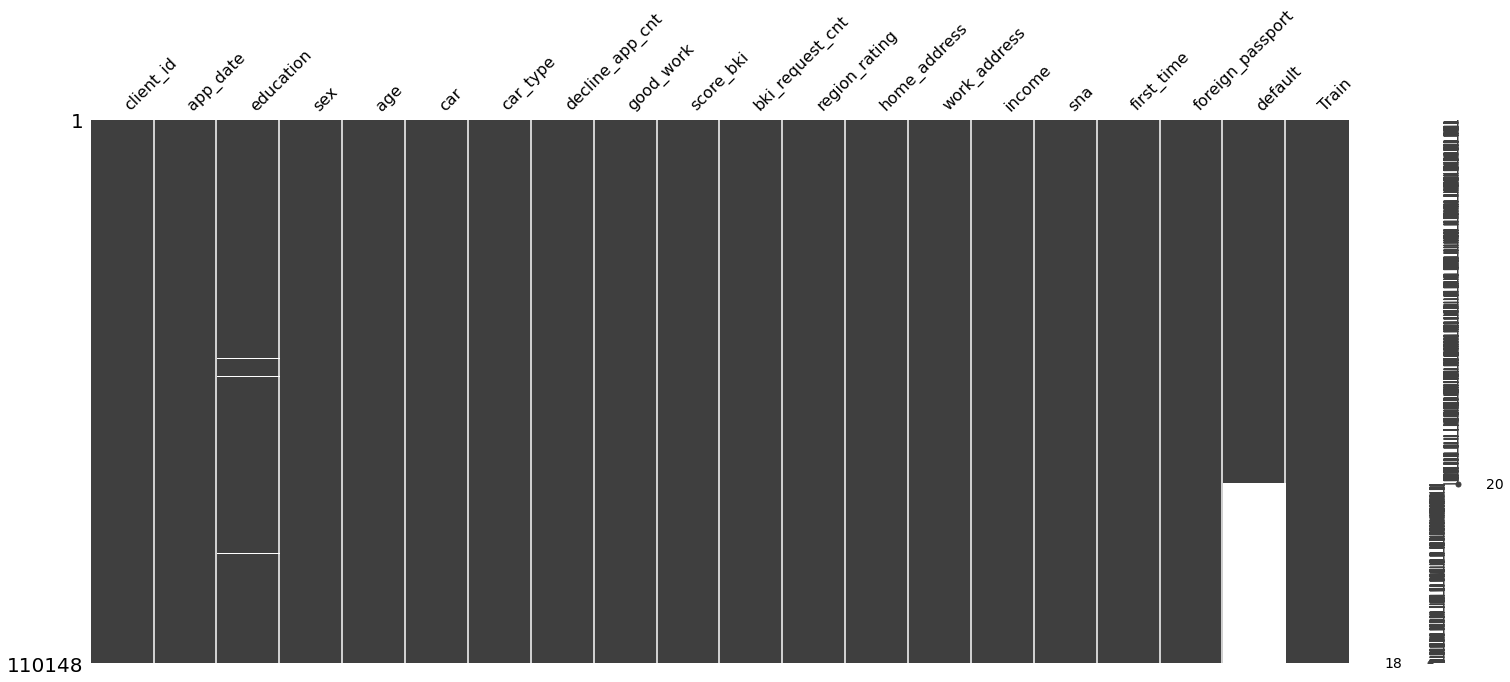

In [224]:
#Рассмотрим количество пропусков
msno.matrix(df) 

Подробнее по признакам:
* **client_id** - идентификатор клиента
* **education** - уровень образования(SCH (школа), UGR (кандидат в бакалавры), GRD (бакалавр), PGR (магистр), ACD (академик))
* **sex** - пол заемщика
* **age** - возраст заемщика
* **car** - флаг наличия автомобиля
* **car_type** - флаг автомобиля иномарки
* **decline_app_cnt** - количество отказанных прошлых заявок 
* **good_work - флаг** наличия “хорошей” работы
* **bki_request_cnt** - количество запросов в БКИ
* **home_address** - категоризатор домашнего адреса
* **work_address** - категоризатор рабочего адреса
* **income** - доход заемщика
* **foreign_passport** - наличие загранпаспорта
* **sna** - связь заемщика с клиентами банка
* **first_time** - давность наличия информации о заемщике
* **score_bki** - скоринговый балл по данным из БКИ
* **region_rating** - рейтинг региона
* **app_date** - дата подачи заявки
* **default** - флаг дефолта по кредиту

In [225]:
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (5, без default)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (6)
cat_cols = ['region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'education']
# числовые переменные, исключили из списка (5, без client_id)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

## 3. Analysis of columns

### 3.1 Numeric 

In [226]:
# составим функции обработки столбцов
def process_numerical(column):
    '''Функция обработки числовых столбцов'''
    
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    median = df[column].median()
    IQR    = perc75 - perc25
    range_min = df[column].min()
    range_max = df[column].max()   
    range_hist = (range_min, range_max)
    nan_count = df[column].isna().sum()
    emissions = df[column].loc[(df[column] < perc25 - 1.5*IQR) | (df[column] > perc75 + 1.5*IQR)]
    
    df[column].describe();
    print('Количество пропусков в столбце: '.format(nan_count),
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        'IQR: {}, '.format(IQR))
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(emissions))
     
    df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                    .hist(bins = 15, range = range_hist, color = 'blue', label = 'IQR')
    
    emissions.hist(bins = 15, range = range_hist, color = 'red', label = 'Выбросы')
     
    plt.legend()

### **Age**

Количество пропусков в столбце:  25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0, 
Границы выбросов: [3.0, 75.0]. Количество выбросов:  0


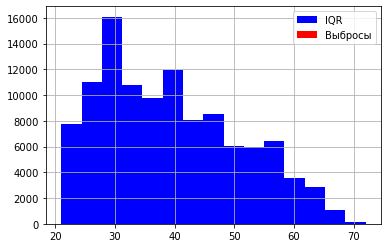

In [227]:
process_numerical('age')

In [228]:
df['age'] = np.log(df['age'] + 1)

**Вывод** : Распределение логнормальное, выбросов нет. Взяли логарифм от признака.

### **Decline_app_cnt**

Количество пропусков в столбце:  25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0, 
Границы выбросов: [0.0, 0.0]. Количество выбросов:  18677


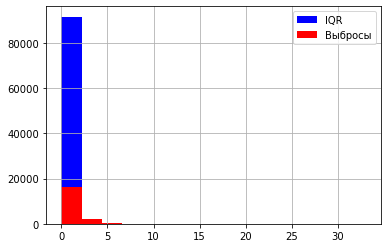

In [229]:
process_numerical('decline_app_cnt')

E:\Pyton\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='decline_app_cnt'>

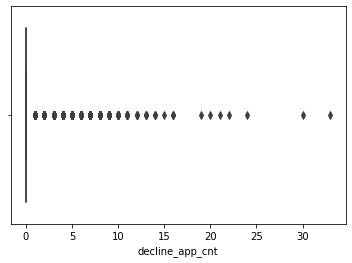

In [230]:
# Столбец содержит выбросы
sns.boxplot(df['decline_app_cnt'])

**Вывод** : Распределение логнормальное, выбросов очень много, взяли логарифм от признака.

### **Bki_request_cnt**

Количество пропусков в столбце:  25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0, 
Границы выбросов: [-4.5, 7.5]. Количество выбросов:  2636


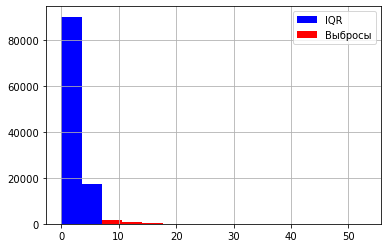

In [231]:
process_numerical('bki_request_cnt')

E:\Pyton\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



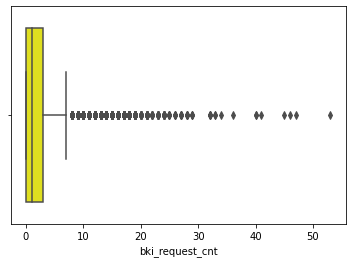

In [232]:
# Столбец содержит выбросы
sns.boxplot(df.bki_request_cnt, color='yellow');

In [233]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

**Вывод** : Распределение логнормальное, выбросов меньше, взяли логарифм от признака.

### **Income**

Количество пропусков в столбце:  25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0, 
Границы выбросов: [-22000.0, 90000.0]. Количество выбросов:  7000


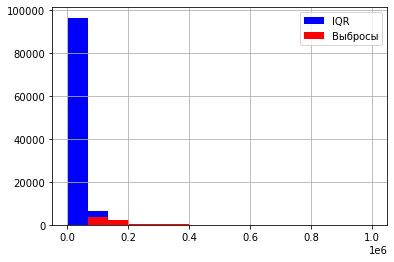

In [234]:
process_numerical('income')

E:\Pyton\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



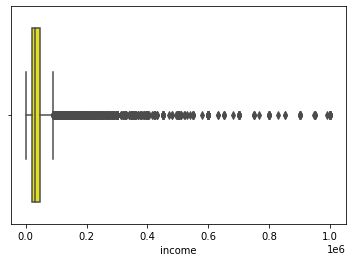

In [235]:
sns.boxplot(df.income, color='yellow');

In [236]:
df['income'] = np.log(df['income'] + 1)

**Вывод** : Распределение логнормальное, выбросов очень много, взяли логарифм от признака.

### **Score_bki**

Количество пропусков в столбце:  25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004, 
Границы выбросов: [-3.299251946250001, -0.5290698762499992]. Количество выбросов:  518


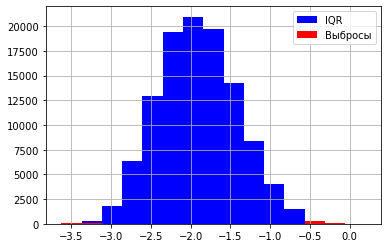

In [237]:
process_numerical('score_bki')

E:\Pyton\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



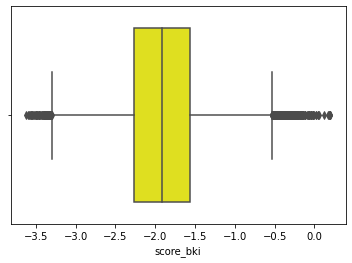

In [238]:
sns.boxplot(df.score_bki, color='yellow');

In [239]:
df['score_bki'] = abs(df['score_bki'])
df['score_bki'] = np.log(df['score_bki'] + 1)

**Вывод** : Распределение логнормальное, выбросов меньше, взяли логарифм от признака.

### 3.2 Categorial 

### **Sna**

In [240]:
df_train['sna'].iplot(kind='histogram', title='Cвязь заемщика с клиентами банка')

### **First_time**

In [241]:
df_train['first_time'].iplot(kind='histogram', title='Давность наличия информации о заемщике')

### **Region_rating**

In [242]:
df_train['region_rating'].iplot(kind='histogram', title='Рейтинг региона')

### **Education**

In [243]:
df_train['education'].iplot(kind='histogram', title='Уровень образования')

In [244]:
(df_train['education'].isna()).sum()

307

In [245]:
# Пропусков меньше 1%, то не будем делать отдельный признак отсутствия информации. Заполним пропуски самым часто 
# встречающимся значением, то есть SCH.
df['education'] = df['education'].fillna('SCH')

### **Добавим новый реквизит - Days**

In [246]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

# Выясняем начало и конец периода нашего датасета
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [247]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')
df_train['days'] = (df.app_date - start).dt.days.astype('int')

## 4. Correlation analysis

<AxesSubplot:>

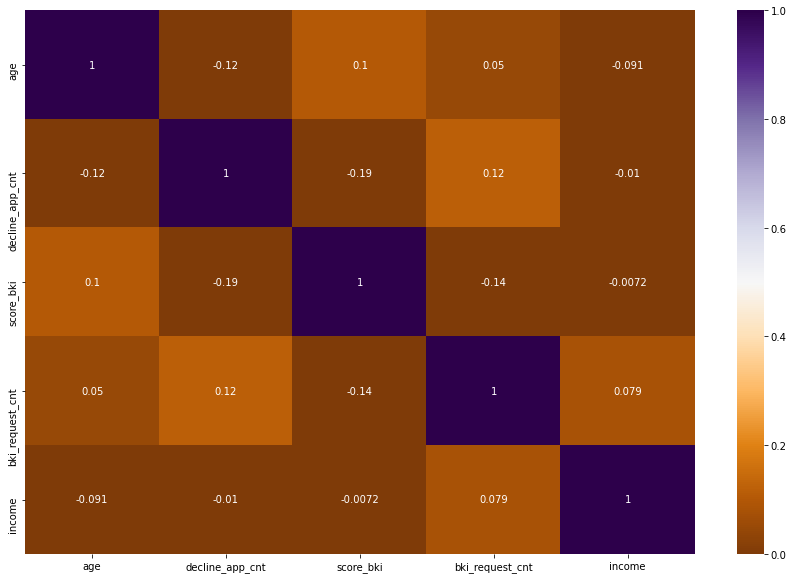

In [248]:
corr = df[num_cols].corr(method='pearson')
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap="PuOr", annot=True, vmin=0, vmax=1)

In [249]:
df[num_cols].corr()

age  decline_app_cnt  score_bki  bki_request_cnt  \
age              1.000000        -0.118243   0.104708         0.050241   
decline_app_cnt -0.118243         1.000000  -0.191858         0.118954   
score_bki        0.104708        -0.191858   1.000000        -0.140663   
bki_request_cnt  0.050241         0.118954  -0.140663         1.000000   
income          -0.090734        -0.010118  -0.007246         0.078649   

                   income  
age             -0.090734  
decline_app_cnt -0.010118  
score_bki       -0.007246  
bki_request_cnt  0.078649  
income           1.000000

**Вывод** : Взаимосвязь пар числовых признаков по Пирсону слабая. Максимальный коэффициент 0.205623. Мультиколлинеарность отсутствует, оставляем все числовые признаки для модели

## 5. Feature engineering

In [250]:
# Для категориальных признаков мы будем использовать OneHotEncoder
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [251]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [252]:
#Выполним стандартизацию - мы будем использовать StandardScaler
df[num_cols] = StandardScaler().fit_transform(df[num_cols].values)

In [253]:
#Удалим нечисловой признак 
df.drop(['app_date'], axis=1, inplace=True)

# Удалим признак client_id
df.drop(['client_id'], axis=1, inplace=True)

In [254]:
# Посмотрим что получилось
display(df.head(5))

sex       age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1  1.714029    1         1        -0.341893          0   0.280710   
1    0  1.542867    0         0        -0.341893          0  -0.666534   
2    1 -1.390791    1         0         2.160936          0  -0.942690   
3    0  1.173250    0         0        -0.341893          0   0.368961   
4    1  0.832388    0         0        -0.341893          1  -1.328789   

   bki_request_cnt    income  foreign_passport  default  Train  days  \
0        -0.281790 -0.786080                 0      0.0      1    31   
1         0.770563 -0.708472                 0      0.0      1    70   
2        -0.281790 -0.052834                 1      0.0      1    31   
3         0.333797 -1.629771                 0      0.0      1    22   
4        -0.281790 -0.052834                 1      0.0      1   107   

   region_rating_20  region_rating_30  region_rating_40  region_rating_50  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 1   
2                 0                 0                 0                 0   
3                 0                 0                 0                 1   
4                 0                 0                 0                 0   

   region_rating_60  region_rating_70  region_rating_80  home_address_1  \
0                 0                 0                 0               1   
1                 0                 0                 0               0   
2                 0                 0                 1               1   
3                 0                 0                 0               0   
4                 1                 0                 0               0   

   home_address_2  home_address_3  work_address_1  work_address_2  \
0               0               0               0               1   
1               1               0               0               0   
2               0               0               0               1   
3               1               0               0               0   
4               1               0               0               0   

   work_address_3  sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  \
0               0      0      0      0      1             1             0   
1               1      0      0      0      1             1             0   
2               0      1      0      0      0             0             0   
3               1      1      0      0      0             0             0   
4               1      1      0      0      0             0             0   

   first_time_3  first_time_4  education_ACD  education_GRD  education_PGR  \
0             0             0              0              0              0   
1             0             0              0              0              0   
2             0             1              0              0              0   
3             1             0              0              0              0   
4             0             1              0              1              0   

   education_SCH  education_UGR  
0              1              0  
1              1              0  
2              1              0  
3              1              0  
4              0              0

## 6. Significance analysis

In [255]:
all_cols = list(df.columns)
all_num_cols = num_cols
target_col = ['default']
other_col = ['Train']
all_cat_and_bin_cols = [x for x in all_cols if x not in (all_num_cols+target_col+other_col)]

temp_df = df[df['Train']==1]
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat_and_bin_cols], temp_df['default'], discrete_features =True), 
                    index = all_cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.iplot(kind = 'barh')

## 7. Model building

In [256]:
train_data = df.query('Train == 1').drop(['Train'], axis=1)
test_data = df.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [257]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [258]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (59039, 37), (14760, 37))

**Обучим несколько моделей и сравним результаты различных методов**

In [259]:
# LogisticRegression:
alg_log = LogisticRegression(random_state=RANDOM_SEED)
alg_log.fit(X_train, y_train)
scores = cross_val_score(alg_log, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (logistic regression): {}/{}".format(scores.mean(), scores.std()))

E:\Pyton\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



roc_auc (logistic regression): 0.7375940203960887/0.01297836564936709


In [260]:
# GradientBoosting:
alg_gb = GradientBoostingClassifier(random_state=RANDOM_SEED)
alg_gb.fit(X_train, y_train)
scores = cross_val_score(alg_gb, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (gradient boosting): {}/{}".format(scores.mean(), scores.std()))

roc_auc (gradient boosting): 0.7376036344136768/0.012303814833272647


In [261]:
# CatBoost
alg_gb = CatBoostClassifier(eval_metric='AUC',random_state=RANDOM_SEED)
alg_gb.fit(X_train, y_train)
scores = cross_val_score(alg_gb, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (cat boosting): {}/{}".format(scores.mean(), scores.std()))

Learning rate set to 0.058777
0:	total: 13.2ms	remaining: 13.1s
1:	total: 26.4ms	remaining: 13.2s
2:	total: 38.9ms	remaining: 12.9s
3:	total: 50.3ms	remaining: 12.5s
4:	total: 75.5ms	remaining: 15s
5:	total: 88.4ms	remaining: 14.6s
6:	total: 109ms	remaining: 15.5s
7:	total: 125ms	remaining: 15.5s
8:	total: 143ms	remaining: 15.8s
9:	total: 155ms	remaining: 15.4s
10:	total: 167ms	remaining: 15s
11:	total: 180ms	remaining: 14.8s
12:	total: 204ms	remaining: 15.5s
13:	total: 218ms	remaining: 15.3s
14:	total: 233ms	remaining: 15.3s
15:	total: 246ms	remaining: 15.1s
16:	total: 266ms	remaining: 15.4s
17:	total: 292ms	remaining: 15.9s
18:	total: 307ms	remaining: 15.9s
19:	total: 327ms	remaining: 16s
20:	total: 340ms	remaining: 15.8s
21:	total: 362ms	remaining: 16.1s
22:	total: 381ms	remaining: 16.2s
23:	total: 394ms	remaining: 16s
24:	total: 408ms	remaining: 15.9s
25:	total: 421ms	remaining: 15.8s
26:	total: 444ms	remaining: 16s
27:	total: 465ms	remaining: 16.1s
28:	total: 490ms	remaining: 16.4

245:	total: 4.18s	remaining: 12.8s
246:	total: 4.2s	remaining: 12.8s
247:	total: 4.21s	remaining: 12.8s
248:	total: 4.23s	remaining: 12.8s
249:	total: 4.25s	remaining: 12.8s
250:	total: 4.26s	remaining: 12.7s
251:	total: 4.28s	remaining: 12.7s
252:	total: 4.3s	remaining: 12.7s
253:	total: 4.31s	remaining: 12.7s
254:	total: 4.34s	remaining: 12.7s
255:	total: 4.35s	remaining: 12.6s
256:	total: 4.37s	remaining: 12.6s
257:	total: 4.39s	remaining: 12.6s
258:	total: 4.41s	remaining: 12.6s
259:	total: 4.43s	remaining: 12.6s
260:	total: 4.44s	remaining: 12.6s
261:	total: 4.46s	remaining: 12.6s
262:	total: 4.47s	remaining: 12.5s
263:	total: 4.48s	remaining: 12.5s
264:	total: 4.5s	remaining: 12.5s
265:	total: 4.52s	remaining: 12.5s
266:	total: 4.54s	remaining: 12.5s
267:	total: 4.55s	remaining: 12.4s
268:	total: 4.57s	remaining: 12.4s
269:	total: 4.6s	remaining: 12.4s
270:	total: 4.61s	remaining: 12.4s
271:	total: 4.63s	remaining: 12.4s
272:	total: 4.65s	remaining: 12.4s
273:	total: 4.66s	remain

482:	total: 7.96s	remaining: 8.52s
483:	total: 7.97s	remaining: 8.49s
484:	total: 7.98s	remaining: 8.48s
485:	total: 8s	remaining: 8.46s
486:	total: 8.01s	remaining: 8.44s
487:	total: 8.02s	remaining: 8.42s
488:	total: 8.03s	remaining: 8.4s
489:	total: 8.05s	remaining: 8.38s
490:	total: 8.07s	remaining: 8.37s
491:	total: 8.08s	remaining: 8.35s
492:	total: 8.1s	remaining: 8.33s
493:	total: 8.12s	remaining: 8.32s
494:	total: 8.14s	remaining: 8.3s
495:	total: 8.15s	remaining: 8.29s
496:	total: 8.17s	remaining: 8.27s
497:	total: 8.18s	remaining: 8.25s
498:	total: 8.2s	remaining: 8.24s
499:	total: 8.22s	remaining: 8.22s
500:	total: 8.23s	remaining: 8.2s
501:	total: 8.25s	remaining: 8.18s
502:	total: 8.26s	remaining: 8.16s
503:	total: 8.28s	remaining: 8.14s
504:	total: 8.29s	remaining: 8.13s
505:	total: 8.31s	remaining: 8.11s
506:	total: 8.32s	remaining: 8.09s
507:	total: 8.34s	remaining: 8.08s
508:	total: 8.36s	remaining: 8.07s
509:	total: 8.38s	remaining: 8.05s
510:	total: 8.39s	remaining:

723:	total: 11.8s	remaining: 4.49s
724:	total: 11.8s	remaining: 4.47s
725:	total: 11.8s	remaining: 4.45s
726:	total: 11.8s	remaining: 4.43s
727:	total: 11.8s	remaining: 4.42s
728:	total: 11.9s	remaining: 4.41s
729:	total: 11.9s	remaining: 4.39s
730:	total: 11.9s	remaining: 4.37s
731:	total: 11.9s	remaining: 4.36s
732:	total: 11.9s	remaining: 4.34s
733:	total: 11.9s	remaining: 4.32s
734:	total: 12s	remaining: 4.31s
735:	total: 12s	remaining: 4.29s
736:	total: 12s	remaining: 4.27s
737:	total: 12s	remaining: 4.26s
738:	total: 12s	remaining: 4.24s
739:	total: 12s	remaining: 4.22s
740:	total: 12s	remaining: 4.21s
741:	total: 12.1s	remaining: 4.19s
742:	total: 12.1s	remaining: 4.17s
743:	total: 12.1s	remaining: 4.16s
744:	total: 12.1s	remaining: 4.14s
745:	total: 12.1s	remaining: 4.12s
746:	total: 12.1s	remaining: 4.11s
747:	total: 12.1s	remaining: 4.09s
748:	total: 12.2s	remaining: 4.07s
749:	total: 12.2s	remaining: 4.06s
750:	total: 12.2s	remaining: 4.04s
751:	total: 12.2s	remaining: 4.03s

962:	total: 15.5s	remaining: 597ms
963:	total: 15.6s	remaining: 581ms
964:	total: 15.6s	remaining: 565ms
965:	total: 15.6s	remaining: 549ms
966:	total: 15.6s	remaining: 532ms
967:	total: 15.6s	remaining: 516ms
968:	total: 15.6s	remaining: 500ms
969:	total: 15.6s	remaining: 484ms
970:	total: 15.7s	remaining: 468ms
971:	total: 15.7s	remaining: 452ms
972:	total: 15.7s	remaining: 436ms
973:	total: 15.7s	remaining: 419ms
974:	total: 15.7s	remaining: 403ms
975:	total: 15.7s	remaining: 387ms
976:	total: 15.7s	remaining: 371ms
977:	total: 15.8s	remaining: 355ms
978:	total: 15.8s	remaining: 338ms
979:	total: 15.8s	remaining: 322ms
980:	total: 15.8s	remaining: 306ms
981:	total: 15.8s	remaining: 290ms
982:	total: 15.8s	remaining: 274ms
983:	total: 15.9s	remaining: 258ms
984:	total: 15.9s	remaining: 242ms
985:	total: 15.9s	remaining: 225ms
986:	total: 15.9s	remaining: 209ms
987:	total: 15.9s	remaining: 193ms
988:	total: 15.9s	remaining: 177ms
989:	total: 15.9s	remaining: 161ms
990:	total: 16s	rema

**Вывод** : Более точной оказалась модель после метода CatBoost. Сформируем для этой модели матрицу ошибок и ROC кривую.

### Confusion matrix

Confusion matrix, without normalization
[[12847    86]
 [ 1768    59]]


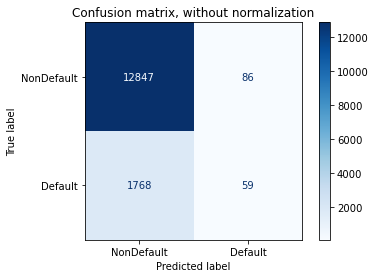

In [262]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix, without normalization", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(alg_gb, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### ROC curve

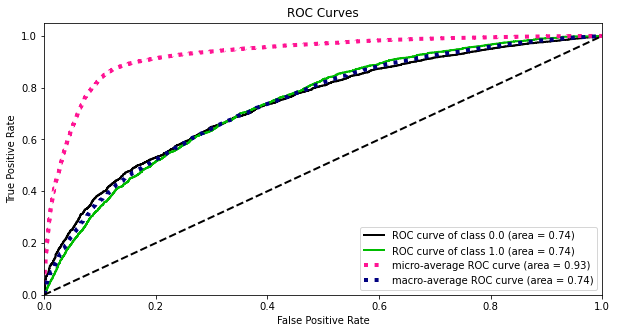

In [263]:
y_probas = alg_gb.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, y_probas, figsize=(10,5))
plt.show()

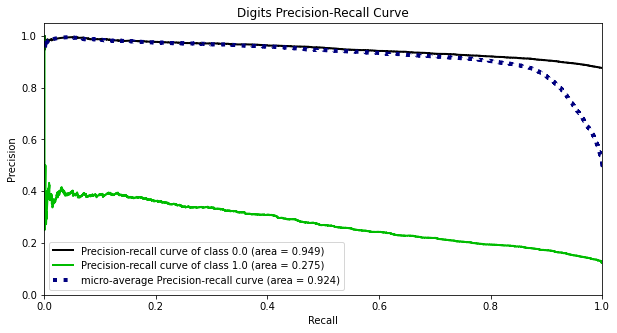

In [264]:
skplt.metrics.plot_precision_recall(y_test, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

**Вывод** : Модель Catboost показала лучший результат чем остальные. Сформируем итоговую модель на ее основании. 

## 8. Submission

In [43]:
train_data = df.query('Train == 1').drop(['Train'], axis=1)
test_data = df.query('Train == 0').drop(['Train'], axis=1)

In [44]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [45]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (73799,), (36349, 37))

In [46]:
model = CatBoostClassifier(eval_metric='AUC',random_state=RANDOM_SEED)

In [47]:
model.fit(X_train,y_train)

Learning rate set to 0.064653
0:	total: 174ms	remaining: 2m 53s
1:	total: 190ms	remaining: 1m 34s
2:	total: 208ms	remaining: 1m 9s
3:	total: 227ms	remaining: 56.5s
4:	total: 242ms	remaining: 48.1s
5:	total: 272ms	remaining: 45s
6:	total: 290ms	remaining: 41.2s
7:	total: 306ms	remaining: 37.9s
8:	total: 319ms	remaining: 35.1s
9:	total: 333ms	remaining: 33s
10:	total: 354ms	remaining: 31.8s
11:	total: 387ms	remaining: 31.9s
12:	total: 402ms	remaining: 30.6s
13:	total: 418ms	remaining: 29.5s
14:	total: 439ms	remaining: 28.8s
15:	total: 485ms	remaining: 29.8s
16:	total: 507ms	remaining: 29.3s
17:	total: 517ms	remaining: 28.2s
18:	total: 533ms	remaining: 27.5s
19:	total: 554ms	remaining: 27.2s
20:	total: 575ms	remaining: 26.8s
21:	total: 603ms	remaining: 26.8s
22:	total: 620ms	remaining: 26.4s
23:	total: 636ms	remaining: 25.8s
24:	total: 665ms	remaining: 26s
25:	total: 698ms	remaining: 26.2s
26:	total: 713ms	remaining: 25.7s
27:	total: 727ms	remaining: 25.3s
28:	total: 745ms	remaining: 24.9

247:	total: 5.1s	remaining: 15.5s
248:	total: 5.12s	remaining: 15.4s
249:	total: 5.14s	remaining: 15.4s
250:	total: 5.16s	remaining: 15.4s
251:	total: 5.18s	remaining: 15.4s
252:	total: 5.2s	remaining: 15.3s
253:	total: 5.22s	remaining: 15.3s
254:	total: 5.24s	remaining: 15.3s
255:	total: 5.27s	remaining: 15.3s
256:	total: 5.29s	remaining: 15.3s
257:	total: 5.31s	remaining: 15.3s
258:	total: 5.32s	remaining: 15.2s
259:	total: 5.34s	remaining: 15.2s
260:	total: 5.36s	remaining: 15.2s
261:	total: 5.39s	remaining: 15.2s
262:	total: 5.4s	remaining: 15.1s
263:	total: 5.43s	remaining: 15.2s
264:	total: 5.46s	remaining: 15.1s
265:	total: 5.48s	remaining: 15.1s
266:	total: 5.5s	remaining: 15.1s
267:	total: 5.51s	remaining: 15.1s
268:	total: 5.54s	remaining: 15.1s
269:	total: 5.55s	remaining: 15s
270:	total: 5.58s	remaining: 15s
271:	total: 5.59s	remaining: 15s
272:	total: 5.62s	remaining: 15s
273:	total: 5.63s	remaining: 14.9s
274:	total: 5.65s	remaining: 14.9s
275:	total: 5.68s	remaining: 14.

487:	total: 9.98s	remaining: 10.5s
488:	total: 9.99s	remaining: 10.4s
489:	total: 10s	remaining: 10.4s
490:	total: 10s	remaining: 10.4s
491:	total: 10.1s	remaining: 10.4s
492:	total: 10.1s	remaining: 10.4s
493:	total: 10.1s	remaining: 10.3s
494:	total: 10.1s	remaining: 10.3s
495:	total: 10.1s	remaining: 10.3s
496:	total: 10.2s	remaining: 10.3s
497:	total: 10.2s	remaining: 10.3s
498:	total: 10.2s	remaining: 10.2s
499:	total: 10.2s	remaining: 10.2s
500:	total: 10.2s	remaining: 10.2s
501:	total: 10.2s	remaining: 10.2s
502:	total: 10.3s	remaining: 10.1s
503:	total: 10.3s	remaining: 10.1s
504:	total: 10.3s	remaining: 10.1s
505:	total: 10.3s	remaining: 10.1s
506:	total: 10.3s	remaining: 10.1s
507:	total: 10.4s	remaining: 10s
508:	total: 10.4s	remaining: 10s
509:	total: 10.4s	remaining: 10s
510:	total: 10.4s	remaining: 9.97s
511:	total: 10.4s	remaining: 9.95s
512:	total: 10.5s	remaining: 9.93s
513:	total: 10.5s	remaining: 9.9s
514:	total: 10.5s	remaining: 9.88s
515:	total: 10.5s	remaining: 9.

725:	total: 14.6s	remaining: 5.53s
726:	total: 14.7s	remaining: 5.5s
727:	total: 14.7s	remaining: 5.49s
728:	total: 14.7s	remaining: 5.46s
729:	total: 14.7s	remaining: 5.44s
730:	total: 14.7s	remaining: 5.42s
731:	total: 14.8s	remaining: 5.4s
732:	total: 14.8s	remaining: 5.38s
733:	total: 14.8s	remaining: 5.36s
734:	total: 14.8s	remaining: 5.34s
735:	total: 14.8s	remaining: 5.33s
736:	total: 14.9s	remaining: 5.3s
737:	total: 14.9s	remaining: 5.28s
738:	total: 14.9s	remaining: 5.26s
739:	total: 14.9s	remaining: 5.24s
740:	total: 14.9s	remaining: 5.22s
741:	total: 15s	remaining: 5.2s
742:	total: 15s	remaining: 5.18s
743:	total: 15s	remaining: 5.16s
744:	total: 15s	remaining: 5.13s
745:	total: 15s	remaining: 5.11s
746:	total: 15s	remaining: 5.09s
747:	total: 15.1s	remaining: 5.07s
748:	total: 15.1s	remaining: 5.05s
749:	total: 15.1s	remaining: 5.03s
750:	total: 15.1s	remaining: 5.01s
751:	total: 15.1s	remaining: 4.99s
752:	total: 15.2s	remaining: 4.97s
753:	total: 15.2s	remaining: 4.95s
7

965:	total: 19.3s	remaining: 680ms
966:	total: 19.3s	remaining: 660ms
967:	total: 19.4s	remaining: 640ms
968:	total: 19.4s	remaining: 620ms
969:	total: 19.4s	remaining: 600ms
970:	total: 19.4s	remaining: 580ms
971:	total: 19.5s	remaining: 560ms
972:	total: 19.5s	remaining: 540ms
973:	total: 19.5s	remaining: 520ms
974:	total: 19.5s	remaining: 500ms
975:	total: 19.5s	remaining: 480ms
976:	total: 19.5s	remaining: 460ms
977:	total: 19.6s	remaining: 440ms
978:	total: 19.6s	remaining: 420ms
979:	total: 19.6s	remaining: 400ms
980:	total: 19.6s	remaining: 380ms
981:	total: 19.6s	remaining: 360ms
982:	total: 19.7s	remaining: 340ms
983:	total: 19.7s	remaining: 320ms
984:	total: 19.7s	remaining: 300ms
985:	total: 19.7s	remaining: 280ms
986:	total: 19.7s	remaining: 260ms
987:	total: 19.8s	remaining: 240ms
988:	total: 19.8s	remaining: 220ms
989:	total: 19.8s	remaining: 200ms
990:	total: 19.8s	remaining: 180ms
991:	total: 19.8s	remaining: 160ms
992:	total: 19.8s	remaining: 140ms
993:	total: 19.9s	re

In [48]:
y_pred_prob = model.predict_proba(X_test)[:,1]

In [49]:
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission1609.csv', index=False)